In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/train_data

/content/drive/MyDrive/train_data


# Directory Structure

📂 images

├── 🖼️ images1.jpg

├── 🖼️ images2.jpg

📂 labels

├── 📄 image1.txt

├── 📄 image2.txt

### Import Libraries


In [22]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt


##Define the Custom Dataset for Multi‑Box Data


Each image’s labels are read from its corresponding text file. If an image has multiple objects, all boxes are returned.

In [23]:
class CustomYOLODataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_filenames = sorted(os.listdir(img_folder))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.img_folder, img_name)
        image = Image.open(img_path).convert("RGB")

        label_path = os.path.join(self.label_folder, img_name.replace(".jpg", ".txt"))
        boxes = []
        # For one-class data we ignore the class value (assume always 0)
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    # Expected format: 0 x_center y_center width height
                    if len(parts) == 5:
                        # Append the coordinates (ignore the first value)
                        boxes.append(np.array(parts[1:], dtype=np.float32))
        # If no boxes found, create a dummy box
        if len(boxes) == 0:
            boxes = [np.zeros(4, dtype=np.float32)]

        if self.transform:
            image = self.transform(image)

        # Return image tensor and boxes as a NumPy array of shape [N, 4]
        return image, np.array(boxes)


##Convert Ground Truth Boxes to a Grid Target
We use a grid of size S×S (S = 7) and assign an object to a cell if its center falls into that cell. For simplicity, we assign the object to the first box slot.

In [24]:
# Global parameters
S = 7           # Grid size
B = 2           # Number of boxes per cell
# Since we have one class and no class probabilities, each box predicts 5 numbers.
final_output_dim = B * 5  # 2 * 5 = 10

def convert_targets(boxes, S=S, B=B):
    # Create an empty target of shape [S, S, final_output_dim]
    target = np.zeros((S, S, final_output_dim), dtype=np.float32)
    cell_size = 1.0 / S
    for box in boxes:
        x, y, w, h = box  # all normalized [0,1]
        col = int(x / cell_size)
        row = int(y / cell_size)
        if row >= S: row = S - 1
        if col >= S: col = S - 1
        # Relative center coordinates within the cell
        cell_x = (x - col * cell_size) / cell_size
        cell_y = (y - row * cell_size) / cell_size
        # If the first box slot is empty (confidence==0), assign the object here.
        if target[row, col, 4] == 0:
            target[row, col, 0:5] = [cell_x, cell_y, w, h, 1.0]
        # (For multiple objects in the same cell, one could assign the second slot.)
    return target


##Define a Custom Collate Function
This function creates the grid target for each sample and converts it to a torch tensor.

In [25]:
def custom_collate_fn_multi(batch):
    images = []
    targets = []
    for image, boxes in batch:
        images.append(image)
        t = convert_targets(boxes, S=S, B=B)
        targets.append(torch.from_numpy(t))
    images = torch.stack(images, 0)
    targets = torch.stack(targets, 0)
    return images, targets


## Define the YOLO‑Style Model
A simple CNN backbone that outputs predictions on a grid. Input images are resized to 128×128.

In [26]:
class YOLOMulti(nn.Module):
    def __init__(self):
        super(YOLOMulti, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # halves dimensions
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # For 128x128 input: after three poolings, spatial size becomes 16x16.
        self.fc1 = nn.Linear(64 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, S * S * final_output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 -> 32
        x = self.pool(F.relu(self.conv3(x)))  # 32 -> 16
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, S, S, final_output_dim)
        # Use sigmoid so that outputs are in [0,1]
        x = torch.sigmoid(x)
        return x

model = YOLOMulti()


##Define the Loss Function
This loss function reshapes predictions and targets to [batch, S, S, B, 5] and then computes coordinate and confidence losses. We call .contiguous() before reshaping

In [27]:
def yolo_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    batch_size = pred.size(0)
    # Ensure pred and target are contiguous and have the expected shape: [batch, S, S, B, 5]
    pred = pred.contiguous().view(batch_size, S, S, B, 5)
    target = target.contiguous().view(batch_size, S, S, B, 5)

    # Now both pred and target should have shape [batch, 7, 7, 2, 5]
    # Create object masks based on target confidence
    obj_mask = (target[..., 4] > 0).float()  # shape: [batch, S, S, B]
    noobj_mask = 1 - obj_mask

    # Coordinate loss (for x, y, w, h) only where objects exist
    coord_loss = lambda_coord * torch.sum(obj_mask.unsqueeze(-1) * ((pred[..., 0:4] - target[..., 0:4]) ** 2))
    # Confidence loss for cells with objects
    conf_loss_obj = torch.sum(obj_mask * ((pred[..., 4] - target[..., 4]) ** 2))
    # Confidence loss for cells without objects
    conf_loss_noobj = lambda_noobj * torch.sum(noobj_mask * ((pred[..., 4]) ** 2))

    loss = coord_loss + conf_loss_obj + conf_loss_noobj
    return loss



##Set Up DataLoader and the Training Loop
Make sure to adjust the folder paths if needed.

In [28]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

img_folder = "images"    # Adjust if needed
label_folder = "labels"    # Adjust if needed

dataset = CustomYOLODataset(img_folder, label_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn_multi)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

for epoch in range(epochs):
    running_loss = 0.0
    for images, targets in dataloader:
        optimizer.zero_grad()
        pred = model(images)
        loss = yolo_loss(pred, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}")


Epoch 1/30, Loss: 32.9036
Epoch 2/30, Loss: 17.3146
Epoch 3/30, Loss: 14.0497
Epoch 4/30, Loss: 11.1051
Epoch 5/30, Loss: 8.9840
Epoch 6/30, Loss: 8.4615
Epoch 7/30, Loss: 6.9283
Epoch 8/30, Loss: 5.8633
Epoch 9/30, Loss: 4.4117
Epoch 10/30, Loss: 3.9774
Epoch 11/30, Loss: 3.3297
Epoch 12/30, Loss: 2.8767
Epoch 13/30, Loss: 2.6083
Epoch 14/30, Loss: 2.6277
Epoch 15/30, Loss: 2.4697
Epoch 16/30, Loss: 2.4731
Epoch 17/30, Loss: 1.8468
Epoch 18/30, Loss: 1.6828
Epoch 19/30, Loss: 1.5518
Epoch 20/30, Loss: 1.2040
Epoch 21/30, Loss: 1.0391
Epoch 22/30, Loss: 0.8974
Epoch 23/30, Loss: 0.7776
Epoch 24/30, Loss: 0.6908
Epoch 25/30, Loss: 0.6237
Epoch 26/30, Loss: 0.6297
Epoch 27/30, Loss: 0.5547
Epoch 28/30, Loss: 0.4586
Epoch 29/30, Loss: 0.4658
Epoch 30/30, Loss: 0.4622


##Save the Trained Model

In [ ]:
torch.save(model.state_dict(), "yolo_multi_one_class.pth")
print("Model saved successfully!")

##Define Functions for Prediction Extraction & Visualization
These functions extract predicted boxes from the model’s grid output and draw them on the image.

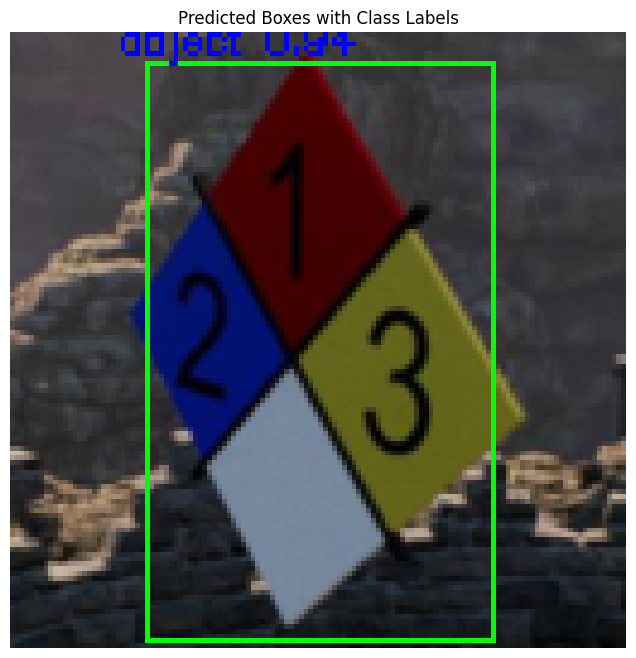

In [62]:
# Update extraction function to return boxes, class_ids, and confidences.
def extract_boxes_from_output(output, conf_threshold=0.2):
    boxes = []
    class_ids = []
    confidences = []
    cell_size = 1.0 / S
    # Reshape output to [S, S, B, 5]
    output = output.reshape(S, S, B, 5)
    for i in range(S):
        for j in range(S):
            for b in range(B):
                cell_pred = output[i, j, b]
                conf = cell_pred[4]
                if conf > conf_threshold:
                    cell_x, cell_y, w, h = cell_pred[:4]
                    # Convert cell-relative coordinates to normalized image coordinates
                    x_abs = (j + cell_x) * cell_size
                    y_abs = (i + cell_y) * cell_size
                    boxes.append([x_abs, y_abs, w, h])
                    # For one-class data, assign class id 0 for each box.
                    class_ids.append(0)
                    confidences.append(conf)
    return boxes, class_ids, confidences

# Update drawing function to include the class name and confidence on each bounding box.
def draw_bounding_boxes(image, boxes, class_ids, confidences, class_names, color=(0, 255, 0)):
    image = np.ascontiguousarray(image)
    height, width = image.shape[:2]
    for bbox, cls, conf in zip(boxes, class_ids, confidences):
        x, y, w, h = bbox
        x1 = int((x - w/2) * width)
        y1 = int((y - h/2) * height)
        x2 = int((x + w/2) * width)
        y2 = int((y + h/2) * height)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        # Lookup class name (default to "object" if not found)
        label = class_names.get(cls, "object")
        # Append confidence to the label, formatted to 2 decimal places.
        label_text = f"{label} {conf:.2f}"
        cv2.putText(image, label_text, (x1-6, y1-2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.27, (0,0,255), 1)
    return image


# Example usage for visualization:

# Define a mapping for class names
class_names = {0: "object"}
sample_image, gt_boxes = dataset[20]
# Assume 'sample_image' is a tensor from your dataset and model has been run on it.
# Convert sample image to NumPy array for visualization:
sample_image_np = np.transpose(sample_image.numpy(), (1, 2, 0))
sample_image_np = (sample_image_np * 255).astype(np.uint8)

# Run model on sample image (add batch dimension if needed)
sample_input = sample_image.unsqueeze(0)
model.eval()
with torch.no_grad():
    pred = model(sample_input)
pred = pred[0].cpu().numpy()  # Shape: [S, S, final_output_dim]

# Extract predicted boxes and class IDs:
# Extract predicted boxes, class IDs, and confidences:
predicted_boxes, predicted_class_ids, predicted_confidences = extract_boxes_from_output(pred, conf_threshold=0.2)

# Draw boxes with class names and confidence scores on the image:
result_img = draw_bounding_boxes(sample_image_np.copy(), predicted_boxes, predicted_class_ids, predicted_confidences, class_names)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(result_img)
plt.title("Predicted Boxes with Class Labels")
plt.axis("off")
plt.show()
